In [3]:
import os
import sys
import opendatasets as od
from joblib import parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation, pyplot, rc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.utils import resample
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from datetime import datetime, time
import json 


# garbage collector so we can save memory
import gc

# Problem Statement and Objectives


# Data Colection


## Importing preprocessed data 


We will be importing data that was merged data of flight dataset from kaggle
and weather from visual crossing (https://www.visualcrossing.com) page. Thanks for cooperation with them,
we were allowed to make large queries about weather in certain places and time.

In [4]:
DATASET_PATH = "/home/meks/Desktop/data_cale.csv"


Lets open it:

In [5]:
pd.set_option('display.max_columns', None)

dataset = pd.read_csv(DATASET_PATH, dtype={'snow':'uint16', 'rain':'uint16','freezingrain':'uint16','ice':'uint16',
                                                 'FL_MONTH':'uint16', 'FL_DAY' : 'uint16', 'FL_YEAR':'uint32', 'OP_CARRIER':'uint16',
                                           'DELAY' : 'uint16'})

#dataset = dataset._append(pd.read_csv(csv_names[len(csv_names) - 1]))



In [6]:
  dataset.head(n=100)

,ID,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,FL_YEAR,FL_MONTH,FL_DAY,ARR_DELAY,DELAY,MOONPHASE,CONDITIONS,CLOUDCOVER,VISIBILITY,PRESSURE,WINDDIR,WINDSPEED,WINDGUST,SNOWDEPTH,SNOW,PRECIPPROB,PRECIP,DEW,HUMIDITY,TEMP,FEELSLIKE,ice,freezingrain,snow,rain,id
0,907.0,5,58,248,655,815,806,140,666,2017,1,1,-9,0,0.12,"Rain, Partially cloudy",81.9,7.6,1021.3,27.0,1.2,NaN,0.0,0.0,100.0,0.001,42.2,90.30,44.9,44.9,0,0,0,1,NaN
1,5833.0,5,58,21,615,725,726,70,192,2017,1,1,1,1,0.12,"Rain, Partially cloudy",81.9,7.6,1021.3,27.0,1.2,NaN,0.0,0.0,100.0,0.001,42.2,90.30,44.9,44.9,0,0,0,1,NaN
2,7651.0,4,58,21,1530,1644,1643,74,192,2017,1,1,-1,0,0.12,Overcast,100.0,3.5,1021.5,85.0,4.5,NaN,0.0,0.0,0.0,0.000,50.8,91.03,53.3,53.3,0,0,0,0,NaN
3,8698.0,4,58,21,828,938,1111,70,192,2017,1,1,173,1,0.12,"Rain, Partially cloudy",64.3,3.8,1021.8,0.0,0.0,NaN,0.0,0.0,100.0,0.014,43.8,91.62,46.1,46.1,0,0,0,1,NaN
4,9237.0,5,58,248,1634,1757,1736,143,666,2017,1,1,-21,0,0.12,"Rain, Overcast",100.0,1.8,1021.6,70.0,5.1,NaN,0.0,0.0,100.0,0.010,51.5,91.61,53.9,53.9,0,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,138280.0,5,58,164,1725,1919,1924,174,878,2017,1,10,5,1,0.44,Clear,17.3,9.9,1028.9,307.0,2.4,NaN,0.0,0.0,0.0,0.000,36.5,44.84,57.8,57.8,0,0,0,0,NaN
96,138377.0,5,58,248,1716,1835,1842,139,666,2017,1,10,7,1,0.44,Clear,17.3,9.9,1028.9,307.0,2.4,NaN,0.0,0.0,0.0,0.000,36.5,44.84,57.8,57.8,0,0,0,0,NaN
97,142458.0,5,58,21,700,820,756,80,192,2017,1,11,-64,0,0.47,Overcast,100.0,9.9,1028.1,332.0,1.2,NaN,0.0,0.0,0.0,0.000,46.7,89.31,49.7,49.7,0,0,0,0,NaN
98,142490.0,5,58,21,2010,2123,2058,73,192,2017,1,11,-65,0,0.47,Clear,15.1,9.9,1026.7,292.0,1.4,NaN,0.0,0.0,0.0,0.000,49.3,68.34,59.7,59.7,0,0,0,0,NaN


In [7]:
dataset.columns.values

array(['ID', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'ARR_DELAY', 'DELAY', 'MOONPHASE',
       'CONDITIONS', 'CLOUDCOVER', 'VISIBILITY', 'PRESSURE', 'WINDDIR',
       'WINDSPEED', 'WINDGUST', 'SNOWDEPTH', 'SNOW', 'PRECIPPROB',
       'PRECIP', 'DEW', 'HUMIDITY', 'TEMP', 'FEELSLIKE', 'ice',
       'freezingrain', 'snow', 'rain', 'id'], dtype=object)

# A small peek on size of data




It's definetely too much, we need to make it smaller, especially the string columns. We would like to convert big string data into mappings of ints to strings. Lets look at example of big columns:

In [9]:
## do wyjebania imo  AIRLINE_DOT,AIRLINE_DOT,DOT_CODE,ORIGIN,DEST ewentualnie zostawic skroty i zrobic jakis slownik do wypisywania
for col_name in dataset.columns.values:
  print(f"Size in mb of {col_name} : {sys.getsizeof(dataset[col_name]) / 10 ** 6} mb, Type {dataset[col_name].dtype}")
print(f"Data size : {sys.getsizeof(dataset) / 10 ** 9} in GB")

Size in mb of ID : 101.20996 mb, Type float64
Size in mb of OP_CARRIER : 25.302598 mb, Type uint16
Size in mb of ORIGIN : 101.20996 mb, Type int64
Size in mb of DEST : 101.20996 mb, Type int64
Size in mb of CRS_DEP_TIME : 101.20996 mb, Type int64
Size in mb of CRS_ARR_TIME : 101.20996 mb, Type int64
Size in mb of ARR_TIME : 101.20996 mb, Type int64
Size in mb of CRS_ELAPSED_TIME : 101.20996 mb, Type int64
Size in mb of DISTANCE : 101.20996 mb, Type int64
Size in mb of FL_YEAR : 50.605052 mb, Type uint32
Size in mb of FL_MONTH : 25.302598 mb, Type uint16
Size in mb of FL_DAY : 25.302598 mb, Type uint16
Size in mb of ARR_DELAY : 101.20996 mb, Type int64
Size in mb of DELAY : 25.302598 mb, Type uint16
Size in mb of MOONPHASE : 101.20996 mb, Type float64
Size in mb of CONDITIONS : 871.02668 mb, Type object
Size in mb of CLOUDCOVER : 101.20996 mb, Type float64
Size in mb of VISIBILITY : 101.20996 mb, Type float64
Size in mb of PRESSURE : 101.20996 mb, Type float64
Size in mb of WINDDIR : 10

# Data Discovery

Info about columns:

In [10]:
print(f"There ara {dataset.shape[0]} rows and {dataset.shape[1]} columns.")

There ara 12651227 rows and 35 columns.


In [11]:
dataset.columns.values

array(['ID', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'ARR_DELAY', 'DELAY', 'MOONPHASE',
       'CONDITIONS', 'CLOUDCOVER', 'VISIBILITY', 'PRESSURE', 'WINDDIR',
       'WINDSPEED', 'WINDGUST', 'SNOWDEPTH', 'SNOW', 'PRECIPPROB',
       'PRECIP', 'DEW', 'HUMIDITY', 'TEMP', 'FEELSLIKE', 'ice',
       'freezingrain', 'snow', 'rain', 'id'], dtype=object)

FL_DATE - Date of flight

AIRLINE -
AIRLINE_DOT
AIRLINE_CODE
DOT_CODE
FL_NUMBER
ORIGIN
ORIGIN_CITY
DEST
DEST_CITY
CRS_DEP_TIME
DEP_TIME
DEP_DELAY
TAXI_OUT
WHEELS_OFF
WHEELS_ON
TAXI_IN
CRS_ARR_TIME
ARR_TIME
ARR_DELAY
CANCELLED
CANCELLATION_CODE
DIVERTED
CRS_ELAPSED_TIME
ELAPSED_TIME
AIR_TIME
DISTANCE
DELAY_DUE_CARRIER
DELAY_DUE_WEATHER
DELAY_DUE_NAS
DELAY_DUE_SECURITY
DELAY_DUE_LATE_AIRCRAFT


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12651227 entries, 0 to 12651226
Data columns (total 35 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ID                float64
 1   OP_CARRIER        uint16 
 2   ORIGIN            int64  
 3   DEST              int64  
 4   CRS_DEP_TIME      int64  
 5   CRS_ARR_TIME      int64  
 6   ARR_TIME          int64  
 7   CRS_ELAPSED_TIME  int64  
 8   DISTANCE          int64  
 9   FL_YEAR           uint32 
 10  FL_MONTH          uint16 
 11  FL_DAY            uint16 
 12  ARR_DELAY         int64  
 13  DELAY             uint16 
 14  MOONPHASE         float64
 15  CONDITIONS        object 
 16  CLOUDCOVER        float64
 17  VISIBILITY        float64
 18  PRESSURE          float64
 19  WINDDIR           float64
 20  WINDSPEED         float64
 21  WINDGUST          float64
 22  SNOWDEPTH         float64
 23  SNOW              float64
 24  PRECIPPROB        float64
 25  PRECIP            float64
 26  DEW         

Mean of delays:

In [13]:
delays = dataset['DELAY']
delays.mean()

0.3773785736355849

Check how many nans in dataframe:

Maybe we should remove windgust? So many NaNs, probably no colleration, ID?

In [14]:

def check_nans():
  # since all len's are same
  n = len(dataset['DELAY'])
  for col in dataset.columns.values:
    nans = dataset[col].isna().sum()
    print(f"Col name: {col} nans: {nans}   {(nans / n) * 100} %")
  print(f"There are {n} rows")

check_nans()


Col name: ID nans: 7071817   55.89826978837705 %
Col name: OP_CARRIER nans: 0   0.0 %
Col name: ORIGIN nans: 0   0.0 %
Col name: DEST nans: 0   0.0 %
Col name: CRS_DEP_TIME nans: 0   0.0 %
Col name: CRS_ARR_TIME nans: 0   0.0 %
Col name: ARR_TIME nans: 0   0.0 %
Col name: CRS_ELAPSED_TIME nans: 0   0.0 %
Col name: DISTANCE nans: 0   0.0 %
Col name: FL_YEAR nans: 0   0.0 %
Col name: FL_MONTH nans: 0   0.0 %
Col name: FL_DAY nans: 0   0.0 %
Col name: ARR_DELAY nans: 0   0.0 %
Col name: DELAY nans: 0   0.0 %
Col name: MOONPHASE nans: 314   0.002481972697193719 %
Col name: CONDITIONS nans: 314   0.002481972697193719 %
Col name: CLOUDCOVER nans: 314   0.002481972697193719 %
Col name: VISIBILITY nans: 5652   0.04467550854948694 %
Col name: PRESSURE nans: 1374   0.010860606643134298 %
Col name: WINDDIR nans: 314   0.002481972697193719 %
Col name: WINDSPEED nans: 314   0.002481972697193719 %
Col name: WINDGUST nans: 9530347   75.33140461395563 %
Col name: SNOWDEPTH nans: 1029781   8.1397717391

# Time for some plots:

Pie graph of delays:

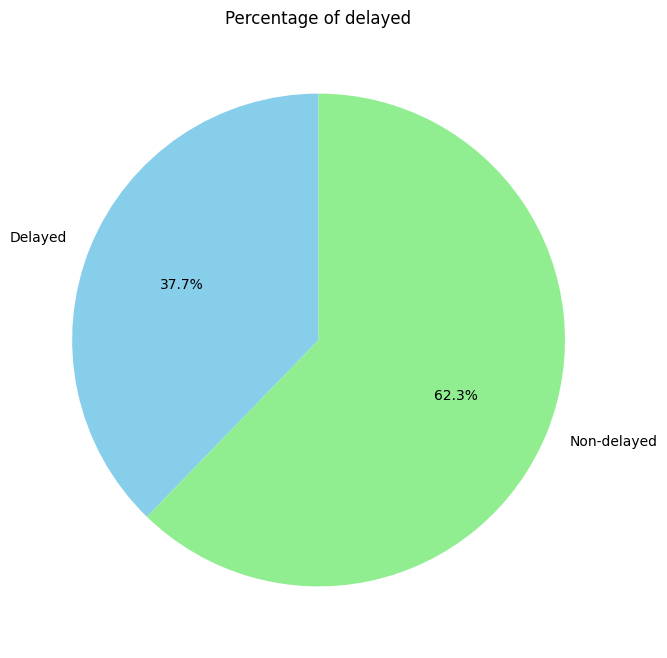

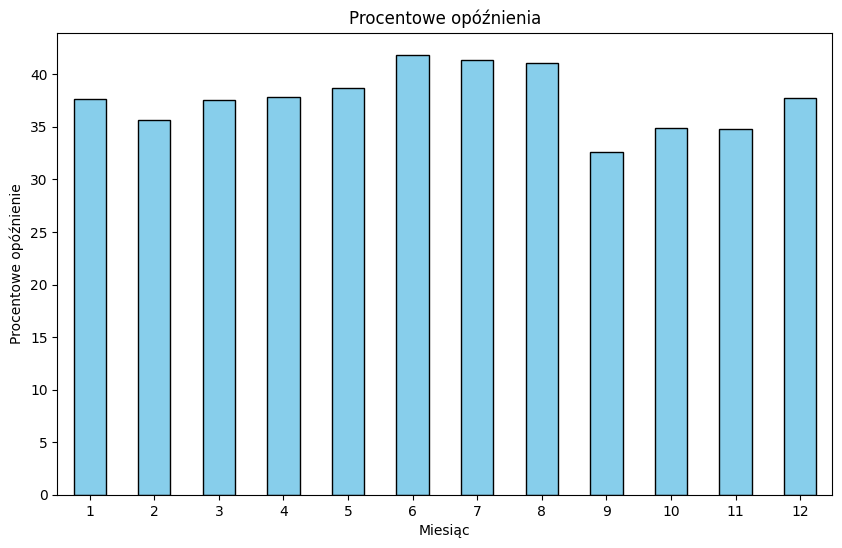

FL_MONTH
1     551022
2     509642
3     592733
4     587626
5     606693
6     612480
7     631207
8     629346
9     576250
10    610334
11    578747
12    585737
Name: id, dtype: int64


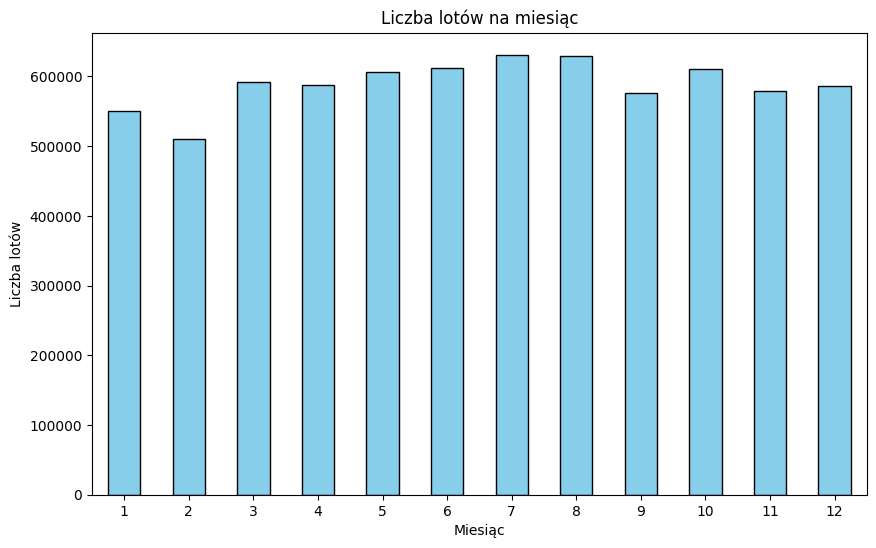

FL_MONTH
1     373383
2     325782
3     402213
4     396217
5     420911
6     460514
7     468945
8     463220
9     332042
10    379274
11    358256
12    393545
Name: DELAY, dtype: uint64


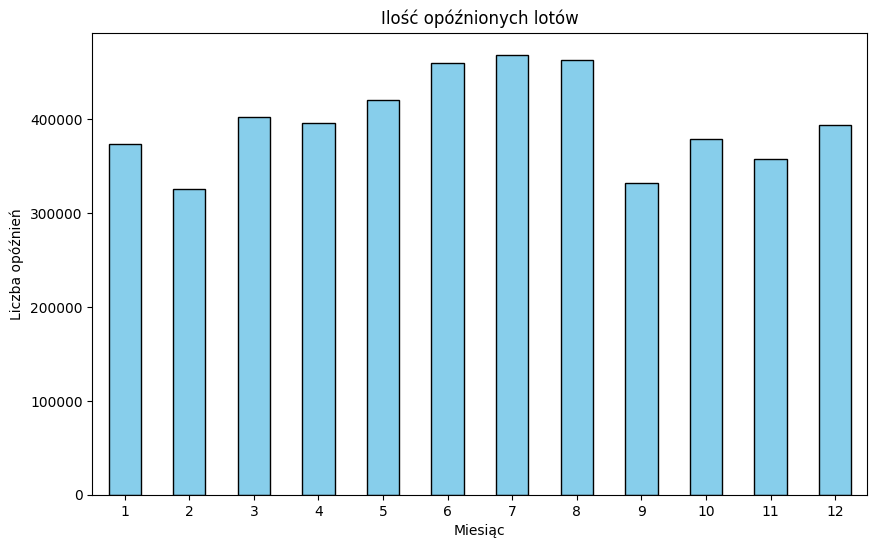

In [15]:
def wykreskolowydelay(df):
    delayed_flights = df[df['DELAY'] > 0]
    percentages = [len(delayed_flights) / len(df) * 100, 100 - len(delayed_flights) / len(df) * 100]
    labels = ['Delayed', 'Non-delayed']
    plt.figure(figsize=(8, 8))
    plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)
    plt.title('Percentage of delayed')
    plt.show()

def wykresmiesiacdealay(df):
    monthly_delays = df.groupby(df['FL_MONTH'])['DELAY'].mean() * 100
    plt.figure(figsize=(10, 6))
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Procentowe opóźnienia')
    plt.xlabel('Miesiąc')
    plt.ylabel('Procentowe opóźnienie')
    plt.xticks(rotation=0)
    plt.show()

def wykresmiesiacliczbalotow(df):
    monthly_delays = df.groupby(df['FL_MONTH'])['id'].count()
    print(monthly_delays)
    plt.figure(figsize=(10, 6))
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Liczba lotów na miesiąc')
    plt.xlabel('Miesiąc')
    plt.ylabel('Liczba lotów')
    plt.xticks(rotation=0)
    plt.show()
def wykresmiesiacopoznienie(df):
    monthly_delays = df.groupby('FL_MONTH')['DELAY'].sum()
    plt.figure(figsize=(10, 6))
    print(monthly_delays)
    monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Ilość opóźnionych lotów')
    plt.xlabel('Miesiąc')
    plt.ylabel('Liczba opóźnień')
    plt.xticks(rotation=0)
    plt.show()

graphs = [wykreskolowydelay, wykresmiesiacdealay, wykresmiesiacliczbalotow, wykresmiesiacopoznienie]

for g in graphs:
    g(dataset)

# Data Preprocessing

## Data Cleaning

Let's remove windgust, since it doesn't provide any important data (does it?) and contains of lots of nans.
Also, 8 percents of snow might be too much. For now, we will remove it and maybe later on we will return it back.

In [16]:
dataset = dataset.drop(['WINDGUST', 'SNOW', "SNOWDEPTH", "ID", "id"], axis = 1, errors = 'ignore')
dataset.head(100)

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,FL_YEAR,FL_MONTH,FL_DAY,ARR_DELAY,DELAY,MOONPHASE,CONDITIONS,CLOUDCOVER,VISIBILITY,PRESSURE,WINDDIR,WINDSPEED,PRECIPPROB,PRECIP,DEW,HUMIDITY,TEMP,FEELSLIKE,ice,freezingrain,snow,rain
0,5,58,248,655,815,806,140,666,2017,1,1,-9,0,0.12,"Rain, Partially cloudy",81.9,7.6,1021.3,27.0,1.2,100.0,0.001,42.2,90.30,44.9,44.9,0,0,0,1
1,5,58,21,615,725,726,70,192,2017,1,1,1,1,0.12,"Rain, Partially cloudy",81.9,7.6,1021.3,27.0,1.2,100.0,0.001,42.2,90.30,44.9,44.9,0,0,0,1
2,4,58,21,1530,1644,1643,74,192,2017,1,1,-1,0,0.12,Overcast,100.0,3.5,1021.5,85.0,4.5,0.0,0.000,50.8,91.03,53.3,53.3,0,0,0,0
3,4,58,21,828,938,1111,70,192,2017,1,1,173,1,0.12,"Rain, Partially cloudy",64.3,3.8,1021.8,0.0,0.0,100.0,0.014,43.8,91.62,46.1,46.1,0,0,0,1
4,5,58,248,1634,1757,1736,143,666,2017,1,1,-21,0,0.12,"Rain, Overcast",100.0,1.8,1021.6,70.0,5.1,100.0,0.010,51.5,91.61,53.9,53.9,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,58,164,1725,1919,1924,174,878,2017,1,10,5,1,0.44,Clear,17.3,9.9,1028.9,307.0,2.4,0.0,0.000,36.5,44.84,57.8,57.8,0,0,0,0
96,5,58,248,1716,1835,1842,139,666,2017,1,10,7,1,0.44,Clear,17.3,9.9,1028.9,307.0,2.4,0.0,0.000,36.5,44.84,57.8,57.8,0,0,0,0
97,5,58,21,700,820,756,80,192,2017,1,11,-64,0,0.47,Overcast,100.0,9.9,1028.1,332.0,1.2,0.0,0.000,46.7,89.31,49.7,49.7,0,0,0,0
98,5,58,21,2010,2123,2058,73,192,2017,1,11,-65,0,0.47,Clear,15.1,9.9,1026.7,292.0,1.4,0.0,0.000,49.3,68.34,59.7,59.7,0,0,0,0


In [17]:
check_nans()

Col name: OP_CARRIER nans: 0   0.0 %
Col name: ORIGIN nans: 0   0.0 %
Col name: DEST nans: 0   0.0 %
Col name: CRS_DEP_TIME nans: 0   0.0 %
Col name: CRS_ARR_TIME nans: 0   0.0 %
Col name: ARR_TIME nans: 0   0.0 %
Col name: CRS_ELAPSED_TIME nans: 0   0.0 %
Col name: DISTANCE nans: 0   0.0 %
Col name: FL_YEAR nans: 0   0.0 %
Col name: FL_MONTH nans: 0   0.0 %
Col name: FL_DAY nans: 0   0.0 %
Col name: ARR_DELAY nans: 0   0.0 %
Col name: DELAY nans: 0   0.0 %
Col name: MOONPHASE nans: 314   0.002481972697193719 %
Col name: CONDITIONS nans: 314   0.002481972697193719 %
Col name: CLOUDCOVER nans: 314   0.002481972697193719 %
Col name: VISIBILITY nans: 5652   0.04467550854948694 %
Col name: PRESSURE nans: 1374   0.010860606643134298 %
Col name: WINDDIR nans: 314   0.002481972697193719 %
Col name: WINDSPEED nans: 314   0.002481972697193719 %
Col name: PRECIPPROB nans: 314   0.002481972697193719 %
Col name: PRECIP nans: 314   0.002481972697193719 %
Col name: DEW nans: 314   0.0024819726971937

Now it would be great if we removed NaN rows, I will remove all NaN rows from MOONPHASE, CONDITIONS etc. I know only by seeing those rows, that there since moonphase and conditions and cloudcover etc. have 0.002481972697193719 % of nans, they have nans on all rows. So i need to remove only moonphase visibility and pressure rows with NaN's.

In [18]:
nan_cols = ["MOONPHASE", 'VISIBILITY', 'PRESSURE']

dataset.dropna(subset = nan_cols, inplace = True)

Now lets look at nans in overall:

In [19]:
check_nans()

Col name: OP_CARRIER nans: 0   0.0 %
Col name: ORIGIN nans: 0   0.0 %
Col name: DEST nans: 0   0.0 %
Col name: CRS_DEP_TIME nans: 0   0.0 %
Col name: CRS_ARR_TIME nans: 0   0.0 %
Col name: ARR_TIME nans: 0   0.0 %
Col name: CRS_ELAPSED_TIME nans: 0   0.0 %
Col name: DISTANCE nans: 0   0.0 %
Col name: FL_YEAR nans: 0   0.0 %
Col name: FL_MONTH nans: 0   0.0 %
Col name: FL_DAY nans: 0   0.0 %
Col name: ARR_DELAY nans: 0   0.0 %
Col name: DELAY nans: 0   0.0 %
Col name: MOONPHASE nans: 0   0.0 %
Col name: CONDITIONS nans: 0   0.0 %
Col name: CLOUDCOVER nans: 0   0.0 %
Col name: VISIBILITY nans: 0   0.0 %
Col name: PRESSURE nans: 0   0.0 %
Col name: WINDDIR nans: 0   0.0 %
Col name: WINDSPEED nans: 0   0.0 %
Col name: PRECIPPROB nans: 0   0.0 %
Col name: PRECIP nans: 0   0.0 %
Col name: DEW nans: 0   0.0 %
Col name: HUMIDITY nans: 0   0.0 %
Col name: TEMP nans: 0   0.0 %
Col name: FEELSLIKE nans: 0   0.0 %
Col name: ice nans: 0   0.0 %
Col name: freezingrain nans: 0   0.0 %
Col name: snow 

We have our data cleaned. Data we imported had ~12.65 mln. rows, after cleaning we have ~12.64 mln. rows. (???)

## Custom Transformers

## Feature Scaling

## Tranformation Pipelines

# Exploratory Data Analysis

# Machine Learning Proccess

In [20]:
def LogREG(X_train,X_test,y_train,y_test):
    model = LogisticRegression(max_iter=1000)

    # Different logistic regression parameters to try
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag']}

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best model from the grid search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print("LR best parameters:", best_params)
    print("Accuracy:", accuracy)

def SVM(X_train, X_test, y_train, y_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Dokładność klasyfikacji: {accuracy:.2f}')

    # Wyświetlanie pełnego raportu klasyfikacji
    print('\nRaport klasyfikacji:')
    print(classification_report(y_test, y_pred))

In [ ]:
'''X = dataset.loc[:, dataset.columns != "DELAY"]
y = dataset["DELAY"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.1)
'''




In [ ]:
#LogREG(X_train, X_test, y_train, y_test)
#SVM(X_train, X_test, y_train, y_test)